In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request

get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('House-Price-Prediction-clean.csv')

In [2]:
dataset.shape

(1460, 32)

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1460 non-null   int64
 1   MSSubClass     1460 non-null   int64
 2   LotArea        1460 non-null   int64
 3   OverallQual    1460 non-null   int64
 4   OverallCond    1460 non-null   int64
 5   YearBuilt      1460 non-null   int64
 6   YearRemodAdd   1460 non-null   int64
 7   BsmtFinSF1     1460 non-null   int64
 8   BsmtUnfSF      1460 non-null   int64
 9   TotalBsmtSF    1460 non-null   int64
 10  1stFlrSF       1460 non-null   int64
 11  2ndFlrSF       1460 non-null   int64
 12  GrLivArea      1460 non-null   int64
 13  BsmtFullBath   1460 non-null   int64
 14  FullBath       1460 non-null   int64
 15  HalfBath       1460 non-null   int64
 16  BedroomAbvGr   1460 non-null   int64
 17  KitchenAbvGr   1460 non-null   int64
 18  TotRmsAbvGrd   1460 non-null   int64
 19  Firepl

In [4]:
dataset.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,567.240411,1057.429452,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,441.866955,438.705324,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,223.000000,795.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,477.500000,991.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,808.000000,1298.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,2336.000000,6110.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone, BaseEstimator, TransformerMixin

In [6]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["HouseArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            # X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["WoodDeckSF"] + ["OpenPorchSF"] + ["PoolArea"]
            # X["HouseAge"] = X["YrSold"] - X["YearBuilt"]
        elif self.additional == 2:
            X["HouseArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["WoodDeckSF"] + X["OpenPorchSF"] + X["PoolArea"]
            # X["HouseAge"] = X["YrSold"] - X["YearBuilt"]
        else :
            X["HouseArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["WoodDeckSF"] + X["OpenPorchSF"] + X["PoolArea"]
            X["HouseAge"]  = X["YrSold"] - X["YearBuilt"]

        return X

In [7]:
# PIPELINE
pipe = Pipeline([('add_feature', CombinedAttributesAdder(additional=3))])
full_data = pd.read_csv('House-Price-Prediction-clean.csv')

FullDataPipe = pipe.fit_transform(full_data.drop('Id',1))

In [8]:
FullDataPipe.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,HouseArea,TotalArea,HouseAge
0,60,8450,7,5,2003,2003,706,150,856,856,...,0,0,0,0,2,2008,208500,2566,3175,5
1,20,9600,6,8,1976,1976,978,284,1262,1262,...,0,0,0,0,5,2007,181500,2524,3282,31
2,60,11250,7,5,2001,2002,486,434,920,920,...,0,0,0,0,9,2008,223500,2706,3356,7
3,70,9550,7,5,1915,1970,216,540,756,961,...,0,0,0,0,2,2006,140000,2473,3150,91
4,60,14260,8,5,2000,2000,655,490,1145,1145,...,0,0,0,0,12,2008,250000,3343,4455,8


In [9]:
corr_matrix = FullDataPipe.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
TotalArea        0.813495
OverallQual      0.790982
HouseArea        0.782260
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
MiscVal         -0.021190
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
HouseAge        -0.523350
Name: SalePrice, dtype: float64

In [10]:
label_1 =  FullDataPipe[FullDataPipe['SalePrice']>100000]
label_2 = label_1[label_1['SalePrice']<400000]

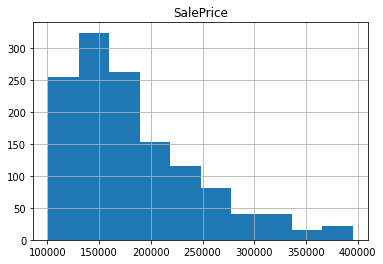

In [11]:
# hist of SalePrice
label_2.hist('SalePrice',bins=10)
plt.show()

In [12]:
# discretize saleprice as salePriceClass from 1-10
label_2['SalePriceClass'] = pd.cut(label_2['SalePrice'],10,labels=[1,2,3,4,5,6,7,8,9,10])

# discretize saleprice as salePriceClass from 1-20

#label_2['SalePriceClass'] = pd.cut(label_2['SalePrice'],20,labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

label_2
#FullDataPipe['SalePriceClass'] = pd.cut(FullDataPipe['SalePrice'],10,labels=[1,2,3,4,5,6,7,8,9,10])

/var/folders/mm/ws64ts1j4vj4yjq605hnx32w0000gn/T/ipykernel_22619/1772287618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_2['SalePriceClass'] = pd.cut(label_2['SalePrice'],10,labels=[1,2,3,4,5,6,7,8,9,10])


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,HouseArea,TotalArea,HouseAge,SalePriceClass
0,60,8450,7,5,2003,2003,706,150,856,856,...,0,0,0,2,2008,208500,2566,3175,5,4
1,20,9600,6,8,1976,1976,978,284,1262,1262,...,0,0,0,5,2007,181500,2524,3282,31,3
2,60,11250,7,5,2001,2002,486,434,920,920,...,0,0,0,9,2008,223500,2706,3356,7,5
3,70,9550,7,5,1915,1970,216,540,756,961,...,0,0,0,2,2006,140000,2473,3150,91,2
4,60,14260,8,5,2000,2000,655,490,1145,1145,...,0,0,0,12,2008,250000,3343,4455,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0,953,953,953,...,0,0,0,8,2007,175000,2600,3100,8,3
1456,20,13175,6,6,1978,1988,790,589,1542,2073,...,0,0,0,2,2010,210000,3615,4464,32,4
1457,70,9042,7,9,1941,2006,275,877,1152,1188,...,0,0,2500,5,2010,266500,3492,3804,69,6
1458,20,9717,5,6,1950,1996,49,0,1078,1078,...,0,0,0,4,2010,142125,2156,2762,60,2


In [13]:
df_clf = label_2.drop('SalePrice',axis=1)


In [14]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

X_class = df_clf.drop('SalePriceClass', 1)
y_class = df_clf['SalePriceClass']
# Creating training and testing sub datasets
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=0)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
dt_clf = DecisionTreeClassifier()

parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(2, 20, 1),
    'min_samples_leaf' : range(1, 10, 1),
    'min_samples_split' : range(2, 10, 1)
}
#fine tune the parameters of the model
gridsear_dt_clf = GridSearchCV(dt_clf, parameters, cv = 5, n_jobs = -1, verbose = 1)
gridsear_dt_clf.fit(X_train, y_train)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [16]:
gridsear_dt_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [17]:
gridsear_dt_clf.best_score_

0.5014673046251994

In [18]:
dt_class = DecisionTreeClassifier(criterion = 'gini', max_depth = 7, min_samples_leaf = 4, min_samples_split = 3, splitter = 'best')
dt_class.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=3)

### tree plot

as we can see from here, total # of samples are the sum of values, and gini index are dropping, the lower the index, the more unifrom (pure) the samples are

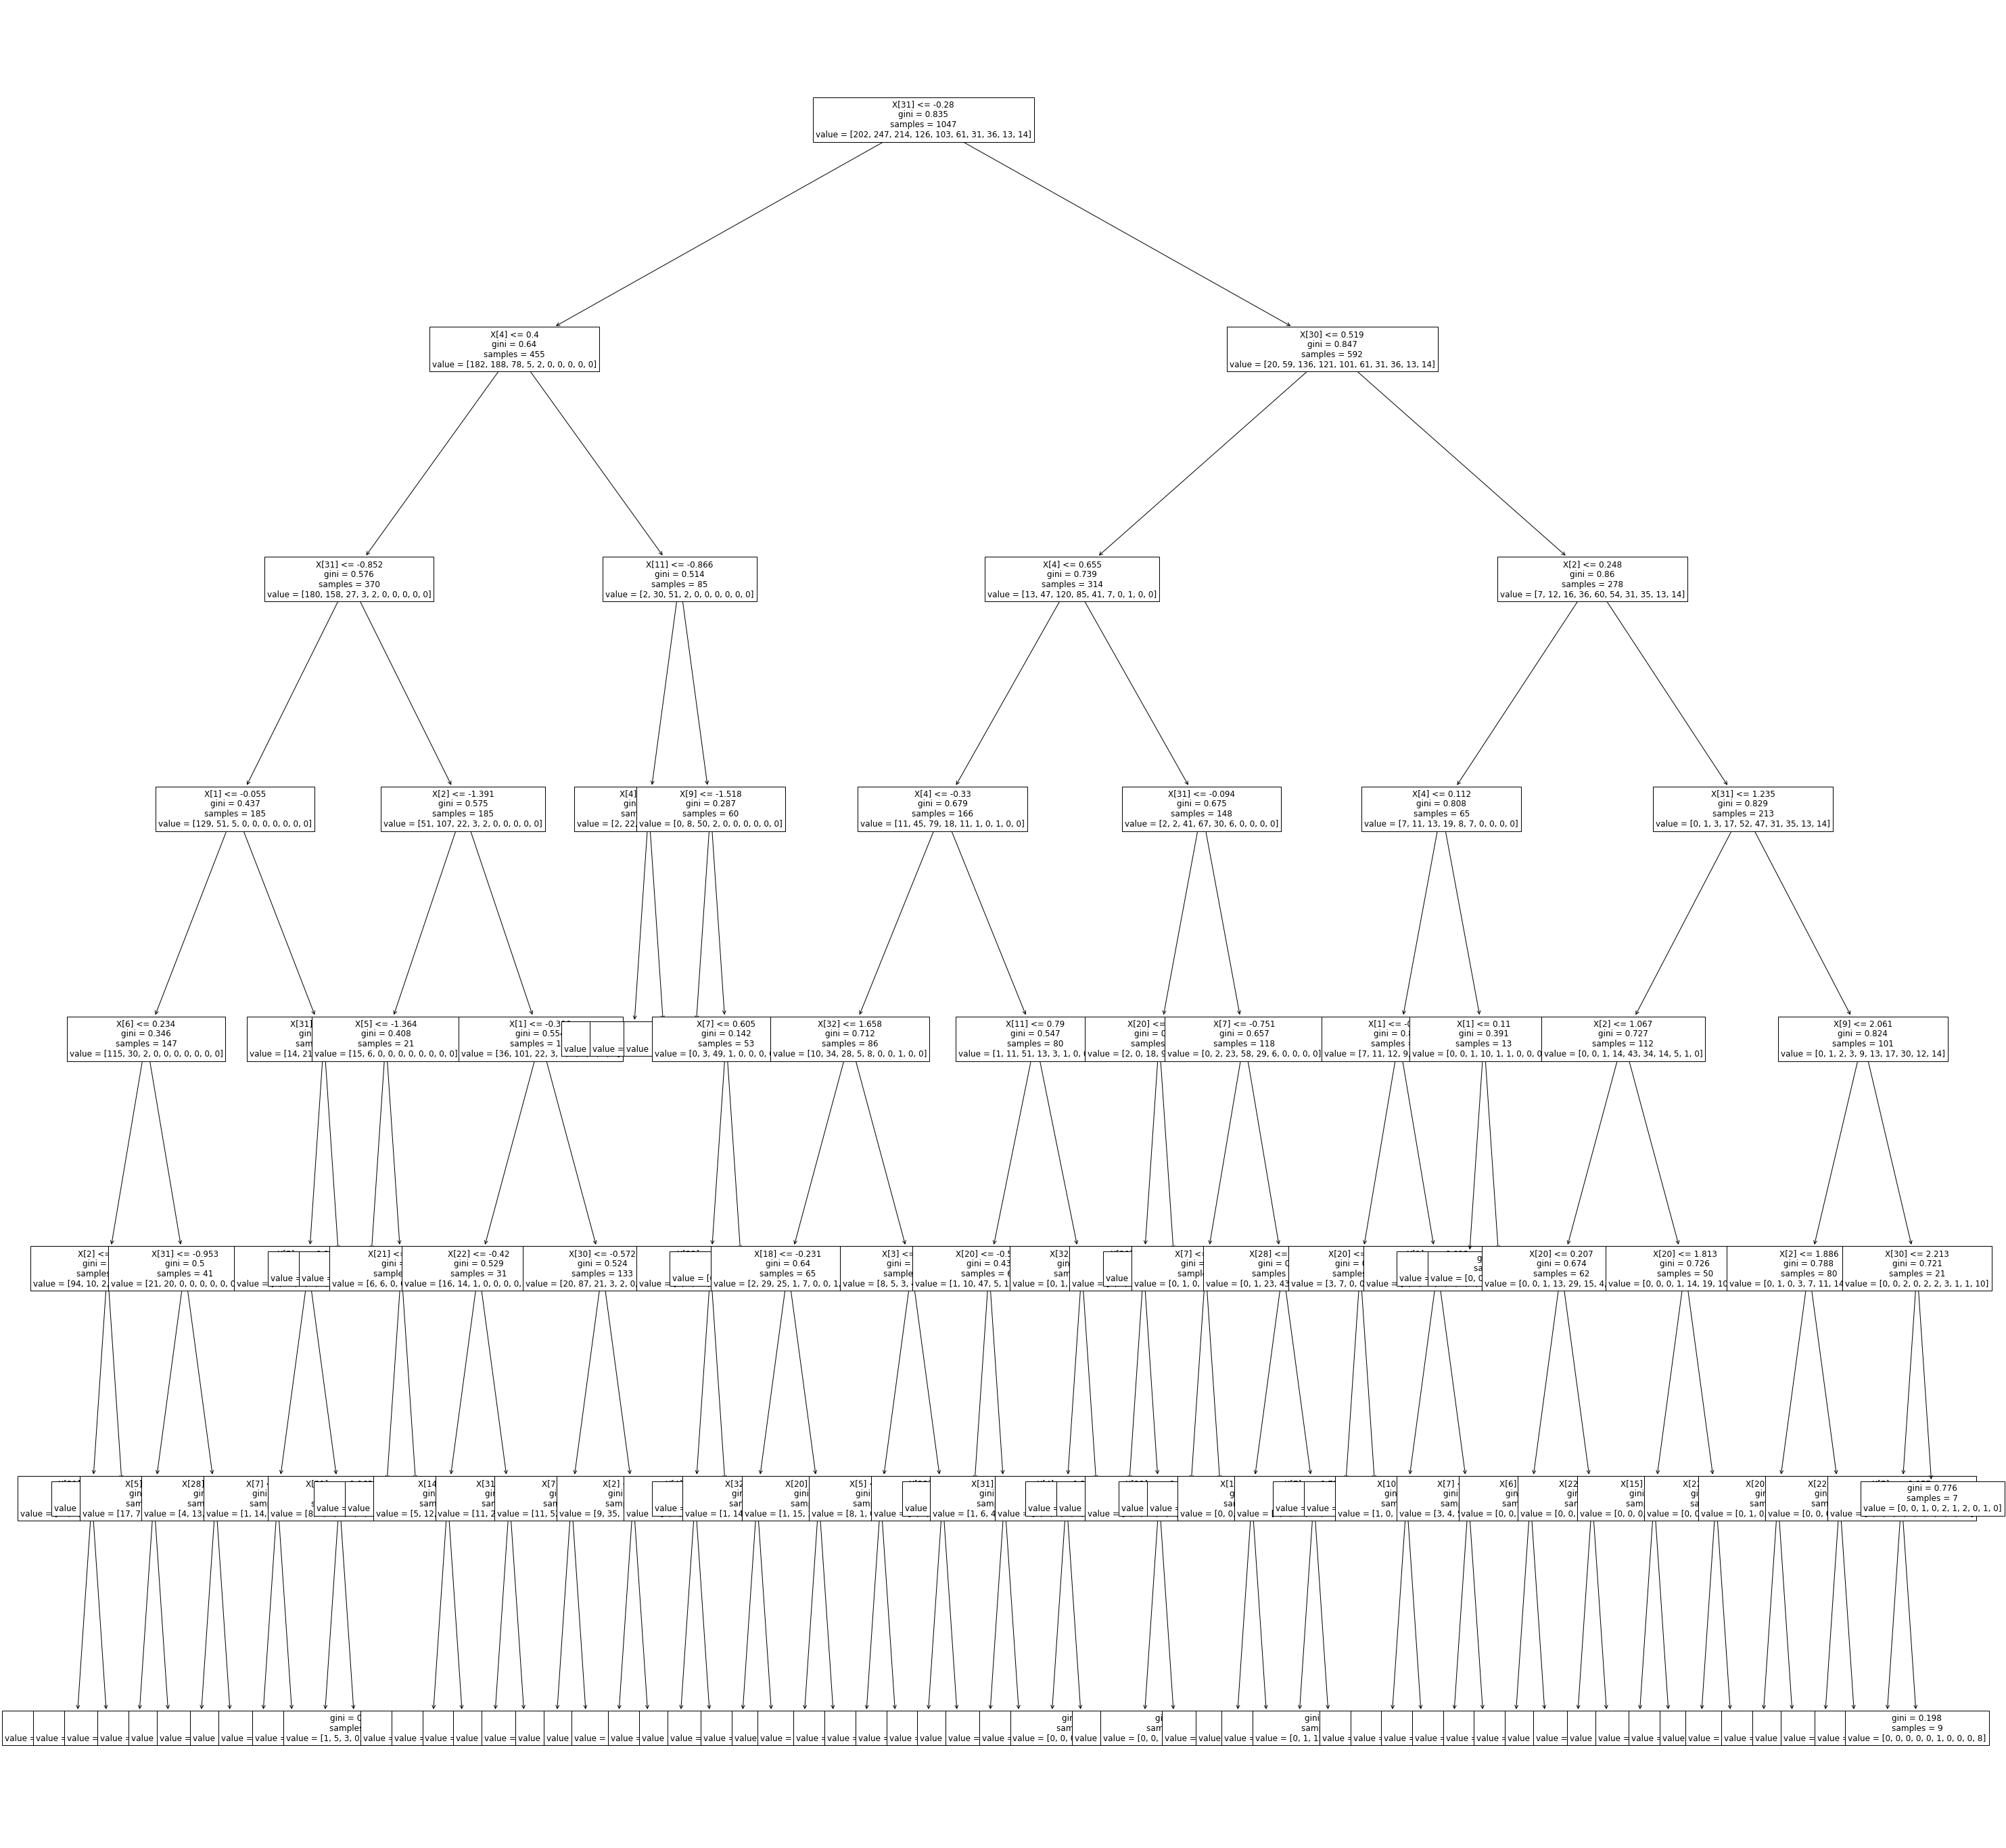

In [19]:
plt.figure(figsize=(50,50))  # set plot size 
tree.plot_tree(dt_class, fontsize=12)
plt.show()

In [20]:
acc_train = accuracy_score(y_train, dt_class.predict(X_train))
print(acc_train)
acc_test = accuracy_score(y_test, dt_class.predict(X_test))
print(acc_test)

0.6914995224450812
0.48854961832061067


In [21]:
y_pred = dt_class.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[40, 10,  2,  0,  0,  0,  0,  0,  0,  0],
       [13, 42, 17,  4,  1,  0,  0,  0,  0,  0],
       [ 2,  9, 26,  5,  5,  0,  0,  0,  0,  1],
       [ 0,  0,  8,  8, 10,  1,  0,  0,  0,  0],
       [ 0,  0,  2,  4,  4,  1,  0,  2,  0,  0],
       [ 0,  0,  1,  0,  9,  5,  0,  3,  2,  0],
       [ 0,  0,  0,  0,  5,  1,  0,  2,  0,  1],
       [ 0,  0,  0,  0,  1,  0,  0,  3,  1,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  3,  2,  0,  2,  1,  0]])

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.77      0.75        52
           2       0.69      0.55      0.61        77
           3       0.46      0.54      0.50        48
           4       0.38      0.30      0.33        27
           5       0.10      0.31      0.15        13
           6       0.50      0.25      0.33        20
           7       0.00      0.00      0.00         9
           8       0.25      0.60      0.35         5
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         8

    accuracy                           0.49       262
   macro avg       0.31      0.33      0.30       262
weighted avg       0.52      0.49      0.49       262



/Users/liujinglei/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liujinglei/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liujinglei/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
dt_class1 = DecisionTreeClassifier(max_depth = 1, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_class1.fit(X_train, y_train)

dt_class2 = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_class2.fit(X_train, y_train)

dt_class3 = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_class3.fit(X_train, y_train)

dt_class4 = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_class4.fit(X_train, y_train)

dt_class5 = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_class5.fit(X_train, y_train)

dt_class6 = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_class6.fit(X_train, y_train)

dt_class7 = DecisionTreeClassifier(max_depth = 50, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_class7.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, min_samples_split=4)

In [24]:
acc_train1 = accuracy_score(y_train, dt_class1.predict(X_train))
print(acc_train1)
acc_test1 = accuracy_score(y_test, dt_class1.predict(X_test))
print(acc_test1)

0.30945558739255014
0.3244274809160305


In [25]:
acc_train2 = accuracy_score(y_train, dt_class2.predict(X_train))
print(acc_train2)
acc_test2 = accuracy_score(y_test, dt_class2.predict(X_test))
print(acc_test2)

0.501432664756447
0.48091603053435117


In [26]:
acc_train3 = accuracy_score(y_train, dt_class3.predict(X_train))
print(acc_train3)
acc_test3 = accuracy_score(y_test, dt_class3.predict(X_test))
print(acc_test3)

0.600764087870105
0.5458015267175572


In [27]:
acc_train4 = accuracy_score(y_train, dt_class4.predict(X_train))
print(acc_train4)
acc_test4 = accuracy_score(y_test, dt_class4.predict(X_test))
print(acc_test4)

0.725883476599809
0.5


In [28]:
acc_train5 = accuracy_score(y_train, dt_class5.predict(X_train))
print(acc_train5)
acc_test5 = accuracy_score(y_test, dt_class5.predict(X_test))
print(acc_test5)

0.8872970391595033
0.5190839694656488


In [29]:
acc_train6 = accuracy_score(y_train, dt_class6.predict(X_train))
print(acc_train6)
acc_test6 = accuracy_score(y_test, dt_class6.predict(X_test))
print(acc_test6)

0.9455587392550143
0.48091603053435117


In [30]:
acc_train7 = accuracy_score(y_train, dt_class7.predict(X_train))
print(acc_train7)
acc_test7 = accuracy_score(y_test, dt_class7.predict(X_test))
print(acc_test7)

0.9455587392550143
0.5038167938931297


In [31]:
from tabulate import tabulate

table = [['model','max_depth', 'accuracy_train' ,'accuracy_test'], ['dt_class1', '1', acc_train1, acc_test1], ['dt_class2', '3', acc_train2, acc_test2],
        ['dt_class3', '5', acc_train3, acc_test3],['dt_class4', '7', acc_train4, acc_test4],['dt_class5', '10', acc_train5, acc_test5],
        ['dt_class6', '15', acc_train6, acc_test6],['dt_class7', '30', acc_train7, acc_test7],['dt_class', '16', acc_train, acc_test]]
         
print(tabulate(table))

---------  ---------  -------------------  -------------------
model      max_depth  accuracy_train       accuracy_test
dt_class1  1          0.30945558739255014  0.3244274809160305
dt_class2  3          0.501432664756447    0.48091603053435117
dt_class3  5          0.600764087870105    0.5458015267175572
dt_class4  7          0.725883476599809    0.5
dt_class5  10         0.8872970391595033   0.5190839694656488
dt_class6  15         0.9455587392550143   0.48091603053435117
dt_class7  30         0.9455587392550143   0.5038167938931297
dt_class   16         0.6914995224450812   0.48854961832061067
---------  ---------  -------------------  -------------------


### 10-fold corss-validation

In [32]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import linear_model, tree, ensemble
from sklearn import svm

In [33]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=60)

cnt=1
for train_index, test_index in kf.split(X_class, y_class):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 1178, Test set:131
Fold:2, Train set: 1178, Test set:131
Fold:3, Train set: 1178, Test set:131
Fold:4, Train set: 1178, Test set:131
Fold:5, Train set: 1178, Test set:131
Fold:6, Train set: 1178, Test set:131
Fold:7, Train set: 1178, Test set:131
Fold:8, Train set: 1178, Test set:131
Fold:9, Train set: 1178, Test set:131
Fold:10, Train set: 1179, Test set:130


In [35]:
score = cross_val_score(dt_class, X_class, y_class, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.53435115 0.45801527 0.49618321 0.49618321 0.47328244 0.45038168
 0.51145038 0.51145038 0.49618321 0.53076923]
Average score: 0.50


### Tree1

In [ ]:
#dt_class = DecisionTreeClassifier(criterion = 'gini', max_depth = 9, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best')
dt_t1 = DecisionTreeClassifier(criterion = 'gini', max_depth = 16, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_t1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=16, min_samples_split=4)

In [ ]:
acc_tr_t1 = accuracy_score(y_train, dt_t1.predict(X_train))
print(acc_tr_t1)
acc_te_t1 = accuracy_score(y_test, dt_t1.predict(X_test))
print(acc_te_t1)

0.9455587392550143
0.4961832061068702


### Tree2

In [ ]:
X_train_t2, X_test_t2, y_train_t2, y_test_t2 = train_test_split(X_class, y_class, test_size=0.5, random_state=0)

In [ ]:
dt_t2 = DecisionTreeClassifier(criterion = 'gini', max_depth = 16, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_t2.fit(X_train_t2, y_train_t2)

acc_tr_t2 = accuracy_score(y_train_t2, dt_t2.predict(X_train_t2))
print(acc_tr_t2)
acc_te_t2 = accuracy_score(y_test_t2, dt_t2.predict(X_test_t2))
print(acc_te_t2)

0.9434250764525994
0.4854961832061069


### Tree3

In [ ]:
X_train_t3, X_test_t3, y_train_t3, y_test_t3 = train_test_split(X_class, y_class, test_size=0.8, random_state=0)


In [ ]:
dt_t3 = DecisionTreeClassifier(criterion = 'gini', max_depth = 16, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
dt_t3.fit(X_train_t3, y_train_t3)

acc_tr_t3 = accuracy_score(y_train_t3, dt_t3.predict(X_train_t3))
print(acc_tr_t3)
acc_te_t3 = accuracy_score(y_test_t3, dt_t3.predict(X_test_t3))
print(acc_te_t3)

0.9386973180076629
0.45229007633587787


# RandomForest

In [ ]:
X_class = df_clf.drop('SalePriceClass', 1)
y_class = df_clf['SalePriceClass']
# Creating training and testing sub datasets
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=0)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier()

parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(2, 20, 1),
    'n_estimators': range(100,500,100)
}
#fine tune the parameters of the model
grid_search_rf = GridSearchCV(rf_clf, parameters, cv = 5, n_jobs = -1, verbose = 1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20),
                         'n_estimators': range(100, 500, 100)},
             verbose=1)

In [ ]:
grid_search_rf.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 400}

In [ ]:
rf_clf = RandomForestClassifier(criterion= 'gini',max_depth = 14, max_features = 'sqrt', n_estimators = 300)
rf_clf.fit(X_train, y_train)

acc_train_rf = accuracy_score(y_train, rf_clf.predict(X_train))
print(acc_train_rf)
acc_test_rf = accuracy_score(y_test, rf_clf.predict(X_test))
print(acc_test_rf)

1.0
0.5954198473282443


In [ ]:
y_pred = rf_clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[42,  9,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 8, 53, 14,  1,  1,  0,  0,  0,  0,  0],
       [ 0,  7, 34,  5,  1,  0,  0,  0,  0,  1],
       [ 0,  0, 12,  9,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  7,  3,  2,  0,  0,  0,  0],
       [ 0,  0,  1,  2,  5,  9,  1,  2,  0,  0],
       [ 0,  0,  0,  0,  2,  2,  2,  3,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  1,  2,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  2,  0,  0],
       [ 0,  0,  0,  1,  0,  1,  0,  4,  0,  2]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.81      0.82        52
           2       0.77      0.69      0.73        77
           3       0.54      0.71      0.61        48
           4       0.36      0.33      0.35        27
           5       0.16      0.23      0.19        13
           6       0.64      0.45      0.53        20
           7       0.40      0.22      0.29         9
           8       0.15      0.40      0.22         5
           9       0.00      0.00      0.00         3
          10       0.67      0.25      0.36         8

    accuracy                           0.60       262
   macro avg       0.45      0.41      0.41       262
weighted avg       0.62      0.60      0.60       262



### 10-fold corss-v

In [ ]:
kf_2 = StratifiedKFold(n_splits=10, shuffle=True, random_state=60)

cnt_2=1
for train_index, test_index in kf_2.split(X_class, y_class):
    print(f'Fold:{cnt_2}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt_2 += 1

Fold:1, Train set: 1178, Test set:131
Fold:2, Train set: 1178, Test set:131
Fold:3, Train set: 1178, Test set:131
Fold:4, Train set: 1178, Test set:131
Fold:5, Train set: 1178, Test set:131
Fold:6, Train set: 1178, Test set:131
Fold:7, Train set: 1178, Test set:131
Fold:8, Train set: 1178, Test set:131
Fold:9, Train set: 1178, Test set:131
Fold:10, Train set: 1179, Test set:130


In [ ]:
score = cross_val_score(rf_clf, X_class, y_class, cv= kf_2, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.61832061 0.61068702 0.54961832 0.6259542  0.55725191 0.55725191
 0.51908397 0.57251908 0.48091603 0.56153846]
Average score: 0.57


### different max_depth comparsion

In [ ]:
rf_clf1 = RandomForestClassifier(criterion= 'gini',max_depth = 1, max_features = 'sqrt', n_estimators = 300)
rf_clf1.fit(X_train, y_train)

rf_clf2 = RandomForestClassifier(criterion= 'gini',max_depth = 3, max_features = 'sqrt', n_estimators = 300)
rf_clf2.fit(X_train, y_train)

rf_clf3 = RandomForestClassifier(criterion= 'gini',max_depth = 5, max_features = 'sqrt', n_estimators = 300)
rf_clf3.fit(X_train, y_train)

rf_clf4 = RandomForestClassifier(criterion= 'gini',max_depth = 7, max_features = 'sqrt', n_estimators = 300)
rf_clf4.fit(X_train, y_train)

rf_clf5 = RandomForestClassifier(criterion= 'gini',max_depth = 9, max_features = 'sqrt', n_estimators = 300)
rf_clf5.fit(X_train, y_train)

rf_clf6 = RandomForestClassifier(criterion= 'gini',max_depth = 10, max_features = 'sqrt', n_estimators = 300)
rf_clf6.fit(X_train, y_train)

rf_clf7 = RandomForestClassifier(criterion= 'gini',max_depth = 12, max_features = 'sqrt', n_estimators = 300)
rf_clf7.fit(X_train, y_train)

rf_clf8 = RandomForestClassifier(criterion= 'gini',max_depth = 16, max_features = 'sqrt', n_estimators = 300)
rf_clf8.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=300)

In [ ]:
acc_train_rf1 = accuracy_score(y_train, rf_clf1.predict(X_train))
acc_test_rf1 = accuracy_score(y_test, rf_clf1.predict(X_test))

acc_train_rf2 = accuracy_score(y_train, rf_clf2.predict(X_train))
acc_test_rf2 = accuracy_score(y_test, rf_clf2.predict(X_test))

acc_train_rf3 = accuracy_score(y_train, rf_clf3.predict(X_train))
acc_test_rf3 = accuracy_score(y_test, rf_clf3.predict(X_test))

acc_train_rf4 = accuracy_score(y_train, rf_clf4.predict(X_train))
acc_test_rf4 = accuracy_score(y_test, rf_clf4.predict(X_test))

acc_train_rf5 = accuracy_score(y_train, rf_clf5.predict(X_train))
acc_test_rf5 = accuracy_score(y_test, rf_clf5.predict(X_test))

acc_train_rf6 = accuracy_score(y_train, rf_clf6.predict(X_train))
acc_test_rf6 = accuracy_score(y_test, rf_clf6.predict(X_test))

acc_train_rf7 = accuracy_score(y_train, rf_clf7.predict(X_train))
acc_test_rf7 = accuracy_score(y_test, rf_clf7.predict(X_test))

acc_train_rf8 = accuracy_score(y_train, rf_clf8.predict(X_train))
acc_test_rf8 = accuracy_score(y_test, rf_clf8.predict(X_test))

In [ ]:
table2 = [['model','max_depth', 'accuracy_train' ,'accuracy_test'], ['rf_clf1', rf_clf1.max_depth, acc_train_rf1, acc_test_rf1]
         ,['rf_clf2', rf_clf2.max_depth, acc_train_rf2, acc_test_rf2],['rf_clf3', rf_clf3.max_depth, acc_train_rf3, acc_test_rf3]
         ,['rf_clf4', rf_clf4.max_depth, acc_train_rf4, acc_test_rf4],['rf_clf5', rf_clf5.max_depth, acc_train_rf5, acc_test_rf5]
         ,['rf_clf6', rf_clf6.max_depth, acc_train_rf5, acc_test_rf5],['rf_clf7', rf_clf7.max_depth, acc_train_rf7, acc_test_rf7]
         ,['rf_clf8', rf_clf8.max_depth, acc_train_rf8, acc_test_rf8],['rf_clf', rf_clf.max_depth, acc_train_rf, acc_test_rf]]
         
print(tabulate(table2))

-------  ---------  ------------------  ------------------
model    max_depth  accuracy_train      accuracy_test
rf_clf1  1          0.3562559694364852  0.3969465648854962
rf_clf2  3          0.5348615090735435  0.5267175572519084
rf_clf3  5          0.7029608404966571  0.5419847328244275
rf_clf4  7          0.8815663801337154  0.5725190839694656
rf_clf5  9          0.9789875835721108  0.583969465648855
rf_clf6  10         0.9789875835721108  0.583969465648855
rf_clf7  12         1.0                 0.5877862595419847
rf_clf8  16         1.0                 0.583969465648855
rf_clf   14         1.0                 0.5954198473282443
-------  ---------  ------------------  ------------------


#### forest2

In [ ]:
X_train_f2, X_test_f2, y_train_f2, y_test_f2 = train_test_split(X_class, y_class, test_size=0.5, random_state=0)

rf_clf_f2 = RandomForestClassifier(criterion= 'gini',max_depth = 14, n_estimators = 300)
rf_clf_f2.fit(X_train_f2, y_train_f2)

acc_train_f2 = accuracy_score(y_train_f2, rf_clf_f2.predict(X_train_f2))
print(acc_train_f2)
acc_test_f2 = accuracy_score(y_test_f2, rf_clf_f2.predict(X_test_f2))
print(acc_test_f2)

1.0
0.5755725190839694


### forest3

In [ ]:
X_train_f3, X_test_f3, y_train_f3, y_test_f3 = train_test_split(X_class, y_class, test_size=0.8, random_state=0)

rf_clf_f3 = RandomForestClassifier(criterion= 'gini',max_depth = 14, n_estimators = 300)
rf_clf_f3.fit(X_train_f3, y_train_f3)

acc_train_f3 = accuracy_score(y_train_f3, rf_clf_f3.predict(X_train_f3))
print(acc_train_f3)
acc_test_f3 = accuracy_score(y_test_f3, rf_clf_f3.predict(X_test_f3))
print(acc_test_f3)

1.0
0.5095419847328244


overfit, seen from the accuracy_score_train vs accuracy_score_test

# Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
#prepare for numeric target feature
data_reg = label_2.drop("SalePriceClass", 1)

In [ ]:
Xr_class = data_reg.drop('SalePrice', 1)
yr_class = data_reg['SalePrice']
# Creating training and testing sub datasets
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr_class, yr_class, test_size=0.2, random_state=0)

scaler = StandardScaler()

Xr_train = scaler.fit_transform(Xr_train)
Xr_test = scaler.transform(Xr_test)

In [ ]:
dt_reg = DecisionTreeRegressor()

parameters = {
    "splitter":["best","random"],
    'max_depth' : range(2, 50, 1),
    'min_samples_leaf' : range(1, 10, 1),
    "min_weight_fraction_leaf": [0,0.1,0.2,0.3,0.4,0.5],
    'min_samples_split' : range(2, 10, 1)
}
#fine tune the parameters of the model
gridsear_dt_reg = GridSearchCV(dt_reg, parameters, cv = 5, n_jobs = -1, verbose = 1)
gridsear_dt_reg.fit(Xr_train, yr_train)

#The minimum weighted fraction of the sum total of weights (of all the input samples) 
#required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

Fitting 5 folds for each of 41472 candidates, totalling 207360 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 50),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5],
                         'splitter': ['best', 'random']},
             verbose=1)

In [ ]:
gridsear_dt_reg.best_params_

{'max_depth': 19,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'splitter': 'random'}

In [ ]:
gridsear_dt_reg.best_score_

0.7146714476017906

In [ ]:
#tuned dt_regressor
dt_reg = DecisionTreeRegressor(max_depth = 19, min_samples_leaf = 7, min_samples_split = 2, splitter = 'best', min_weight_fraction_leaf = 0.1)

#un_tuned dt_regressor
dt_reg_un = DecisionTreeRegressor()

dt_reg.fit(Xr_train, yr_train)
dt_reg_un.fit(Xr_train, yr_train)

# plt.figure(figsize=(50,50))  # set plot size 
# tree.plot_tree(dt_reg, fontsize=12)
# plt.show()

DecisionTreeRegressor()

In [ ]:
score_reg_un_train = dt_reg_un.score(Xr_train, yr_train)
score_reg_un_test = dt_reg_un.score(Xr_test, yr_test)

print(score_reg_un_train)
print(score_reg_un_test)

print("------------------------")

score_reg_train = dt_reg.score(Xr_train, yr_train)
score_reg_test = dt_reg.score(Xr_test, yr_test)

print(score_reg_train)
print(score_reg_test)

1.0
0.7508839065251472
------------------------
0.7313375143772995
0.7054343394407798


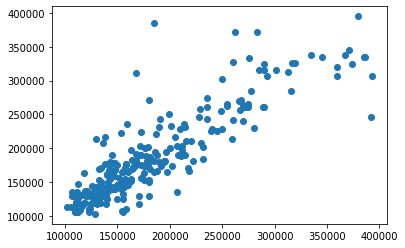

In [ ]:
pred=dt_reg_un.predict(Xr_test)
plt.scatter(yr_test,pred)

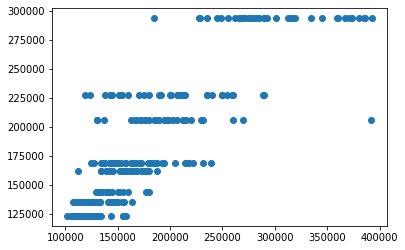

In [ ]:
tuned_pred=dt_reg.predict(Xr_test)
plt.scatter(yr_test,tuned_pred)

In [ ]:
dt_reg1 = DecisionTreeRegressor(max_depth = 1, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', min_weight_fraction_leaf = 0.1)
dt_reg1.fit(Xr_train, yr_train)

dt_reg2 = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', min_weight_fraction_leaf = 0.1)
dt_reg2.fit(Xr_train, yr_train)

dt_reg3 = DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', min_weight_fraction_leaf = 0.1)
dt_reg3.fit(Xr_train, yr_train)

dt_reg4 = DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', min_weight_fraction_leaf = 0.1)
dt_reg4.fit(Xr_train, yr_train)

dt_reg5 = DecisionTreeRegressor(max_depth = 15, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', min_weight_fraction_leaf = 0.1)
dt_reg5.fit(Xr_train, yr_train)

dt_reg6 = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', min_weight_fraction_leaf = 0)
dt_reg6.fit(Xr_train, yr_train)

DecisionTreeRegressor(max_depth=5, min_weight_fraction_leaf=0)

In [ ]:
score_reg_train1 = dt_reg1.score(Xr_train, yr_train)
score_reg_test1 = dt_reg1.score(Xr_test, yr_test)

score_reg_train2 = dt_reg2.score(Xr_train, yr_train)
score_reg_test2 = dt_reg2.score(Xr_test, yr_test)

score_reg_train3 = dt_reg3.score(Xr_train, yr_train)
score_reg_test3 = dt_reg3.score(Xr_test, yr_test)

score_reg_train4 = dt_reg4.score(Xr_train, yr_train)
score_reg_test4 = dt_reg4.score(Xr_test, yr_test)

score_reg_train5 = dt_reg5.score(Xr_train, yr_train)
score_reg_test5 = dt_reg5.score(Xr_test, yr_test)

score_reg_train6 = dt_reg6.score(Xr_train, yr_train)
score_reg_test6 = dt_reg6.score(Xr_test, yr_test)

In [ ]:
table3 = [['model','max_depth', 'score_train' ,'score_test'], ['dt_reg1', dt_reg1.max_depth, score_reg_train1, score_reg_test1]
         ,['dt_reg2', dt_reg2.max_depth, score_reg_train2, score_reg_test2],['dt_reg3', dt_reg3.max_depth, score_reg_train3, score_reg_test3]
         ,['dt_reg4', dt_reg4.max_depth, score_reg_train4, score_reg_test4],['dt_reg5', dt_reg5.max_depth, score_reg_train5, score_reg_test5]
         ,['dt_reg6', dt_reg6.max_depth, score_reg_train6, score_reg_test6],['dt_reg', dt_reg.max_depth, score_reg_train, score_reg_test]
         ,['dt_reg_un', dt_reg_un.max_depth, score_reg_un_train, score_reg_un_test]]
         
print(tabulate(table3))

---------  ---------  ------------------  ------------------
model      max_depth  score_train         score_test
dt_reg1    1          0.5031109641680169  0.4642783192354406
dt_reg2    2          0.6815481553932767  0.6732836369987063
dt_reg3    3          0.7242476071009516  0.7028007920229163
dt_reg4    4          0.7313375143772995  0.7054343394407798
dt_reg5    15         0.7313375143772995  0.7054343394407798
dt_reg6    5          0.8742380313101105  0.7780056619751516
dt_reg     19         0.7313375143772995  0.7054343394407798
dt_reg_un             1.0                 0.7508839065251472
---------  ---------  ------------------  ------------------
